In [85]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import Lipinski, Descriptors, rdMolDescriptors, AllChem, PandasTools
from pandarallel import pandarallel
import numpy as np
pandarallel.initialize(progress_bar=False)
import tmap as tm
from map4 import MAP4Calculator
import os
import joblib
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

folder = "/data/coconut/"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def fp_to_np(fp):
    fp_array = np.zeros(1)
    DataStructs.ConvertToNumpyArray(fp, fp_array)
    return fp_array

In [3]:
coconut = pd.read_pickle(folder + "coconut_prop.pkl")
coconut["ecfp4"] = coconut["ecfp4"].map(fp_to_np)

In [4]:
origins = ["plants", "fungi", "bacteria", "animal", "Homo_sapiens", "marine", "other"]
def origin(simple_tax):
    if simple_tax in origins:
        return origins.index(simple_tax)


In [5]:
coconut["origin"] = coconut.simple_tax.map(origin)

In [6]:
def norm_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    smiles_n = Chem.MolToSmiles(mol, isomericSmiles=False)
    return smiles_n

coconut["norm_smiles"] = coconut["SMILES"].map(norm_smiles) 

In [7]:
from itertools import product

import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.utils import check_matplotlib_support
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.base import is_classifier
import matplotlib

class ConfusionMatrixDisplay:
    """Confusion Matrix visualization.
    It is recommend to use :func:`~sklearn.metrics.plot_confusion_matrix` to
    create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
    attributes.
    Read more in the :ref:`User Guide <visualizations>`.
    Parameters
    ----------
    confusion_matrix : ndarray of shape (n_classes, n_classes)
        Confusion matrix.
    display_labels : ndarray of shape (n_classes,)
        Display labels for plot.
    Attributes
    ----------
    im_ : matplotlib AxesImage
        Image representing the confusion matrix.
    text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text, \
            or None
        Array of matplotlib axes. `None` if `include_values` is false.
    ax_ : matplotlib Axes
        Axes with confusion matrix.
    figure_ : matplotlib Figure
        Figure containing the confusion matrix.
    """
    def __init__(self, confusion_matrix, display_labels):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels

    def plot(self, include_values=True, cmap='viridis',
             xticks_rotation='horizontal', values_format=None, ax=None):
        """Plot visualization.
        Parameters
        ----------
        include_values : bool, default=True
            Includes values in confusion matrix.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                         default='horizontal'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`,
            the format specification is '.2g'.
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        """
        check_matplotlib_support("ConfusionMatrixDisplay.plot")
        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1,)
        self.text_ = None

        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)

        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)
            if values_format is None:
                values_format = '.0%'

            # print text with appropriate color depending on background
            thresh = (cm.max() + cm.min()) / 2.0
            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if cm[i, j] < thresh else cmap_min
                self.text_[i, j] = ax.text(j, i,
                                           format(cm[i, j], values_format),
                                           ha="center", va="center",
                                           color=color, size= 6 )

        
        colorbar = fig.colorbar(self.im_, ax=ax)
        colorbar.ax.tick_params(labelsize=6) 
        colorbar.set_ticks([0, .25, 0.5, .75, 1])
        colorbar.set_ticklabels(['0%', '25%', '50%','75%', '100%'])
        #colorbar.set_label("Predicted value/True Value")
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=self.display_labels,
               yticklabels=self.display_labels,
               ylabel="True label",
               xlabel="Predicted label")

        
        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation, fontsize=6)
        plt.setp(ax.get_yticklabels(), fontsize=6)
        ax.xaxis.get_label().set_fontsize(6)
        ax.yaxis.get_label().set_fontsize(6)
        
        self.figure_ = fig
        self.ax_ = ax

        return self



def plot_confusion_matrix(y_pred, y_true, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None, colorbar=False):

    check_matplotlib_support("plot_confusion_matrix")


    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)


In [8]:
coconut = coconut.query("origin != 6 and origin != 5 and origin != 4 and origin != 3").sort_values("origin", ascending=False)

In [9]:
coconut.replace(["NaN", 'NaT'], np.nan, inplace = True)
coconut = coconut.dropna()

/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/pandas/core/missing.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/pandas/core/missing.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


In [10]:
len(coconut)

60171

In [11]:
coconut["Set"] = "test"
for i in range(3):
    print(i)
    coconut_training = coconut.query("origin == @i").sample(frac=0.50, random_state=12)
    coconut.loc[coconut_training.index, "Set"] = "training"

0
1
2


In [12]:
features = ['molecular_weight','number_of_carbons',\
       'number_of_nitrogens', 'number_of_oxygens',\
       'total_atom_number', 'bond_count', 'topoPSA', 'fcsp3', 'HBA',\
       'HBD', 'aLogP']

In [13]:
for feat in features:
    coconut[f"{feat}"]=coconut[f"{feat}"].map(float) 

In [14]:
def map4_kernel_SVM(a, b=None):
    if b is None:
        b=a
    JS_all_pairs = np.zeros((len(a),len(b)))
    for i,fp1 in enumerate(a):
        for j,fp2 in enumerate(b):
            JS_all_pairs[i,j] = np.float(np.count_nonzero(fp1 == fp2)) / np.float(len(fp1))
    return JS_all_pairs


def tanimoto_kernel_SVM(data_1, data_2):
    """
    Tanimoto kernel
        K(x, y) = <x, y> / (||x||^2 + ||y||^2 - <x, y>)
    as defined in:
    "Graph Kernels for Chemical Informatics"
    Liva Ralaivola, Sanjay J. Swamidass, Hiroto Saigo and Pierre Baldi
    Neural Networks
    https://www.sciencedirect.com/science/article/pii/S0893608005001693
    http://members.cbio.mines-paristech.fr/~jvert/svn/bibli/local/Ralaivola2005Graph.pdf
    """

    norm_1 = (data_1 ** 2).sum(axis=1).reshape(data_1.shape[0], 1)
    norm_2 = (data_2 ** 2).sum(axis=1).reshape(data_2.shape[0], 1)
    prod = data_1.dot(data_2.T)

    divisor = (norm_1 + norm_2.T - prod) + np.finfo(data_1.dtype).eps
    return prod / divisor


def dice_kernel_SVM(data_1, data_2):
    """
    Sorensen kernel
        K(x, y) = 2 <x, y> / (||x||^2 + ||y||^2)
    as defined in:
    "Graph Kernels for Chemical Informatics"
    Liva Ralaivola, Sanjay J. Swamidass, Hiroto Saigo and Pierre Baldi
    Neural Networks
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.92.483&rep=rep1&type=pdf
    """

    norm_1 = (data_1 ** 2).sum(axis=1).reshape(data_1.shape[0], 1)
    norm_2 = (data_2 ** 2).sum(axis=1).reshape(data_2.shape[0], 1)
    prod = data_1.dot(data_2.T)
    return 2 * prod / (norm_1 + norm_2.T)

In [15]:
scores_dict = {"balacc": make_scorer(metrics.balanced_accuracy_score, greater_is_better=True),\
"mcc" : make_scorer(metrics.matthews_corrcoef, greater_is_better=True),\
"f1" : make_scorer(metrics.f1_score, greater_is_better=True, average="micro")} 

In [16]:
metrics_dict = {"balacc": metrics.balanced_accuracy_score,\
"mcc" : metrics.matthews_corrcoef,\
"f1" : lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average="micro")} 

## hyperparameters optimization and preliminary results

In [17]:
features_to_test = {"map4": "MAP4",
                   "ecfp4": "ecfp4",
                  "features": features,
                    "ap": "ap",}

subsets = []
for i in range(3):
    for set_ in ["training", "test"]:
        subsets.append(coconut.query("origin==@i and Set == @set_").sample(frac=0.2, random_state=12))
coconut_subset = pd.concat(subsets)

In [18]:
coconut_subset.groupby(["origin", "Set"]).count()

coconut_id  inchi  inchikey  SMILES  sugar_free_smiles  \
origin Set                                                                
0      test            3377   3377      3377    3377               3377   
       training        3377   3377      3377    3377               3377   
1      test            1565   1565      1565    1565               1565   
       training        1565   1565      1565    1565               1565   
2      test            1075   1075      1075    1075               1075   
       training        1075   1075      1075    1075               1075   

                 molecular_formula  molecular_weight  citationDOI  textTaxa  \
origin Set                                                                    
0      test                   3377              3377         3377      3377   
       training               3377              3377         3377      3377   
1      test                   1565              1565         1565      1565   
       training               1565              1565         1565      1565   
2      test                   1075              1075         1075      1075   
       training               1075              1075         1075      1075   

                 name  ...  has_lipo_chain  has_ring  has_sterol  \
origin Set             ...                                         
0      test      3377  ...            3377      3377        3377   
       training  3377  ...            3377      3377        3377   
1      test      1565  ...            1565      1565        1565   
       training  1565  ...            1565      1565        1565   
2      test      1075  ...            1075      1075        1075   
       training  1075  ...            1075      1075        1075   

                 n_rings_nosugar  mw_nolipidtail_nosugar  smarts  is_terminal  \
origin Set                                                                      
0      test                 3377                    3377    3377         3377   
       training             3377                    3377    3377         3377   
1      test                 1565                    1565    1565         1565   
       training             1565                    1565    1565         1565   
2      test                 1075                    1075    1075         1075   
       training             1075                    1075    1075         1075   

                 ecfp4    ap  norm_smiles  
origin Set                                 
0      test       3377  3377         3377  
       training   3377  3377         3377  
1      test       1565  1565         1565  
       training   1565  1565         1565  
2      test       1075  1075         1075  
       training   1075  1075         1075  

[6 rows x 48 columns]

In [19]:
classifiers_subset = {}
OVERWRITE_FILES = False
for name, feature in features_to_test.items():
    if not os.path.exists(folder +  f"SVM-coconut.{name}.subset.pkl") or OVERWRITE_FILES:
        X = np.vstack(coconut_subset[coconut_subset["Set"] == "training"][feature].to_numpy())
        Y = coconut_subset[coconut_subset["Set"] == "training"].origin.to_numpy()

    
        if name == "map4":
            param_grid = {'svc__C': [0.1,1, 10, 100, 1000], \
                          'svc__kernel': [map4_kernel_SVM]}
            base_clf = make_pipeline(svm.SVC(probability=False, class_weight="balanced", cache_size=1900, random_state=12))
        elif name == "features":
            param_grid = {'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [0.01, 0.1, 1, 10, 100],\
                  'svc__kernel': ["rbf"]}
            base_clf = make_pipeline(StandardScaler(), svm.SVC(probability=False, class_weight="balanced", cache_size=1900, random_state=12))
        else:
            param_grid = {'svc__C': [0.1,1, 10, 100, 1000], \
              'svc__kernel': [tanimoto_kernel_SVM, dice_kernel_SVM]}
            base_clf = make_pipeline(svm.SVC(probability=False, class_weight="balanced", cache_size=1900, random_state=12))

        
        splitter= StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
        grid = GridSearchCV(base_clf, param_grid,\
                            refit="balacc",verbose=2, n_jobs=7, cv=splitter, scoring=scores_dict)

        print(f"Train {name}")
        grid.fit(X,Y)

        if name not in classifiers_subset:
            classifiers_subset[name] = []
        classifiers_subset[name].append(grid)

        joblib.dump(grid, folder + f"SVM-coconut.{name}.subset.pkl")
    else:
        grid = joblib.load(folder + f"SVM-coconut.{name}.subset.pkl")
        if name not in classifiers_subset:
            classifiers_subset[name] = []
        classifiers_subset[name].append(grid)

In [20]:
for name, classifier__ in classifiers_subset.items():
    print(name)
    classifier__ = classifier__[0]
    print(classifier__.best_params_)
    for scorename in scores_dict:
        print(scorename, classifier__.cv_results_[f'mean_test_{scorename}'][classifier__.best_index_], "+-", classifier__.cv_results_[f'std_test_{scorename}'][classifier__.best_index_])
    print()

map4
{'svc__C': 1, 'svc__kernel': <function map4_kernel_SVM at 0x7fb216a6d488>}
balacc 0.8345191726318262 +- 0.010929624167180851
mcc 0.7621281543060106 +- 0.012007080896040684
f1 0.859897183950423 +- 0.006360011854265646

ecfp4
{'svc__C': 1, 'svc__kernel': <function tanimoto_kernel_SVM at 0x7fb216a6db70>}
balacc 0.7856504383073164 +- 0.011649163764654835
mcc 0.6764944306438414 +- 0.016468614074397286
f1 0.8062138397085912 +- 0.010001651192961054

features
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
balacc 0.6878160307868881 +- 0.01278102075526972
mcc 0.5119421518301809 +- 0.016904734417418545
f1 0.6988546076668792 +- 0.009882123633359694

ap
{'svc__C': 10, 'svc__kernel': <function tanimoto_kernel_SVM at 0x7fb216a55c80>}
balacc 0.6218099001395736 +- 0.011825811067320101
mcc 0.432612851026317 +- 0.016650307972408285
f1 0.6591313797455419 +- 0.010773867783152093



In [21]:
for name, feature in features_to_test.items():
    print(name)
    classifier__ = classifiers_subset[name][0]
    
    x = np.vstack(coconut_subset[coconut_subset["Set"] == "test"][feature].to_numpy())
    y_true = coconut_subset[coconut_subset["Set"] == "test"].origin.to_numpy()
        
        
    y_pred = classifier__.predict(x)
    
    for metric_name, metric_fn in metrics_dict.items():
        metric_result = metric_fn(y_true, y_pred) 
        print(metric_name, metric_result)
    

map4
balacc 0.8347488459909123
mcc 0.763635436841331
f1 0.8607279375103872
ecfp4
balacc 0.7854582341121046
mcc 0.6758085741127018
f1 0.8060495263420309
features
balacc 0.684971732185185
mcc 0.5131380118844332
f1 0.701678577364135
ap
balacc 0.642982082794741
mcc 0.45855876493142395
f1 0.6724281203257437


## comparison with ECFP4 AP and properties

In [23]:
classifiers_all = {}

features_to_test = {"map4": "MAP4",
                   "ecfp4": "ecfp4",
                    "ap": "ap",
                  "features": features}


for name, feature in features_to_test.items():
    if not os.path.exists(folder + f"SVM-coconut.{name}.all.pkl"):
        X = np.vstack(coconut[feature].to_numpy())
        Y = coconut.origin.to_numpy()


        if name == "map4":
            param_grid = {'svc__C': [1], \
                          'svc__kernel': [map4_kernel_SVM]}
            base_clf = make_pipeline(svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))
        elif name == "features":
            param_grid = {'svc__C': [1], 'svc__gamma': [1],\
                  'svc__kernel': ["rbf"]}
            base_clf = make_pipeline(StandardScaler(), svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))

        elif name == "ecfp4":
            param_grid = {'svc__C': [1], \
              'svc__kernel': [tanimoto_kernel_SVM]}
            base_clf = make_pipeline(svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))

        else:
            param_grid = {'svc__C': [10], \
              'svc__kernel': [tanimoto_kernel_SVM]}
            base_clf = make_pipeline(svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))


        splitter= StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
        grid = GridSearchCV(base_clf, param_grid,\
                            refit="balacc",verbose=2, n_jobs=1, cv=splitter, scoring=scores_dict)


        print(f"Train {name}")
        grid.fit(X,Y)

        if name not in classifiers_all:
            classifiers_all[name] = []
        classifiers_all[name].append(grid)

        joblib.dump(grid, folder + f"SVM-coconut.{name}.all.pkl")
    else:
        grid = joblib.load(folder + f"SVM-coconut.{name}.all.pkl")
        if name not in classifiers_all:
            classifiers_all[name] = []
        classifiers_all[name].append(grid)

In [24]:
for name, classifier__ in classifiers_all.items():
    print(name)
    classifier__ = classifier__[0]
    print(classifier__.best_params_)
    for scorename in scores_dict:
        print(scorename, classifier__.cv_results_[f'mean_test_{scorename}'][classifier__.best_index_], "+-", classifier__.cv_results_[f'std_test_{scorename}'][classifier__.best_index_])
    print()

map4
{'svc__C': 1, 'svc__kernel': <function map4_kernel_SVM at 0x7fb218bf4c80>}
balacc 0.9194259704079233 +- 0.004517651902782002
mcc 0.8790331865495322 +- 0.004638930035819268
f1 0.9286533978405871 +- 0.0026447328567348887

ecfp4
{'svc__C': 1, 'svc__kernel': <function tanimoto_kernel_SVM at 0x7fb218bf4e18>}
balacc 0.889892247293691 +- 0.004926195555270775
mcc 0.8265960156646223 +- 0.006087527442065774
f1 0.896544889880279 +- 0.0034955353080574464

features
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
balacc 0.757714854807425 +- 0.005229965921990582
mcc 0.6129185594547569 +- 0.0067048501220906415
f1 0.7613137103093651 +- 0.003953601276181542

ap
{'svc__C': 10, 'svc__kernel': <function tanimoto_kernel_SVM at 0x7fb218bf4d90>}
balacc 0.7351336539538783 +- 0.005153346306679389
mcc 0.5922969140488954 +- 0.005847602674722551
f1 0.7525883835986378 +- 0.0036283849992238973



### 95% confidence intervals

In [285]:
for name, classifier__ in classifiers_all.items():
    print(name)
    classifier__ = classifier__[0]
    print(classifier__.best_params_)
    for scorename in scores_dict:
        print(scorename, float(classifier__.cv_results_[f'mean_test_{scorename}'][classifier__.best_index_])+3*(float(classifier__.cv_results_[f'std_test_{scorename}'][classifier__.best_index_])),\
             float(classifier__.cv_results_[f'mean_test_{scorename}'][classifier__.best_index_])-3*(float(classifier__.cv_results_[f'std_test_{scorename}'][classifier__.best_index_])))
    print()

map4
{'svc__C': 1, 'svc__kernel': <function map4_kernel_SVM at 0x7fb218bf4c80>}
balacc 0.9329789261162693 0.9058730146995773
mcc 0.89294997665699 0.8651163964420744
f1 0.9365875964107918 0.9207191992703824

ecfp4
{'svc__C': 1, 'svc__kernel': <function tanimoto_kernel_SVM at 0x7fb218bf4e18>}
balacc 0.9046708339595033 0.8751136606278787
mcc 0.8448585979908196 0.8083334333384249
f1 0.9070314958044514 0.8860582839561066

features
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
balacc 0.7734047525733967 0.7420249570414532
mcc 0.6330331098210289 0.592804009088485
f1 0.7731745141379097 0.7494529064808205

ap
{'svc__C': 10, 'svc__kernel': <function tanimoto_kernel_SVM at 0x7fb218bf4d90>}
balacc 0.7505936928739165 0.7196736150338401
mcc 0.609839722073063 0.5747541060247278
f1 0.7634735385963095 0.741703228600966



In [247]:
df_plot = pd.DataFrame()
simple_list = []
for name, classifier__ in classifiers_all.items():
    classifier__ = classifier__[0]
    if name == "features":
        name = "Prop.\nSVM"
    else:
        name = name.upper()+"\nSVM"
    for i,scorename in enumerate(scores_dict):
        mean = float(classifier__.cv_results_[f'mean_test_{scorename}'][classifier__.best_index_])
        std = float(classifier__.cv_results_[f'std_test_{scorename}'][classifier__.best_index_])
        ymax = mean+2*std
        ymin = mean-2*std
        simple_list.append([name, scorename, mean, ymin, ymax, (std*3)])

df_plot=pd.DataFrame(simple_list,columns=['fingerprint','metric', "mean", "LB", "UB", "int"])

In [296]:
df_plot

df_plot_list_reordered = []
for i in ["MAP4\nSVM", "ECFP4\nSVM", "AP\nSVM", "Prop.\nSVM"]:
    tmp_df__ = df_plot.query("fingerprint == @i")
    df_plot_list_reordered.append(tmp_df__)
    
df_plot = pd.concat(df_plot_list_reordered)


0.0 0.9194259704079233
1.0 0.889892247293691
2.0 0.7351336539538783
3.0 0.757714854807425


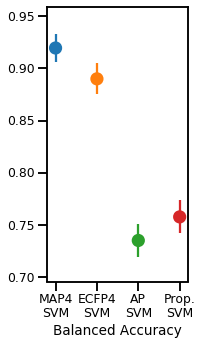

In [297]:
sns.set_context("talk", font_scale=0.75)
fig, ax = plt.subplots(figsize=(3,5))
sns.pointplot(ax =ax, x="fingerprint", y="mean", data=df_plot.query("metric=='balacc'"), dodge=True, join=False, palette=sns.color_palette())
ax.set(xlabel='Balanced Accuracy', ylabel='')
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        print(x,y)
        x_coords.append(x)
        y_coords.append(y)
lb = df_plot.query("metric=='balacc'")["int"].to_list()

ax.errorbar(x_coords, y_coords, yerr=[lb, lb], fmt="none", capsize=0, color=sns.color_palette())
plt.tight_layout()
plt.savefig("plots/balacc.svg")

In [298]:
ax.collections

0.0 0.8790331865495322
1.0 0.8265960156646223
2.0 0.5922969140488954
3.0 0.6129185594547569


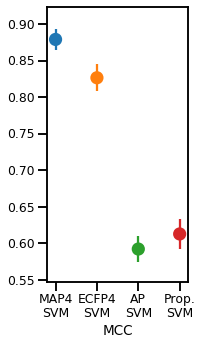

In [299]:
fig, ax = plt.subplots(figsize=(3,5))
sns.pointplot(ax =ax, x="fingerprint", y="mean", data=df_plot.query("metric=='mcc'"), dodge=True, join=False, palette=sns.color_palette())
ax.set(xlabel='MCC', ylabel='')
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        print(x,y)
        x_coords.append(x)
        y_coords.append(y)

lb = df_plot.query("metric=='mcc'")["int"].to_list()
ax.errorbar(x_coords, y_coords, yerr=[lb, lb], fmt="none", capsize=0, color=sns.color_palette())
plt.tight_layout()
plt.savefig("plots/mcc.svg")

0.0 0.9286533978405871
1.0 0.896544889880279
2.0 0.7525883835986378
3.0 0.7613137103093651


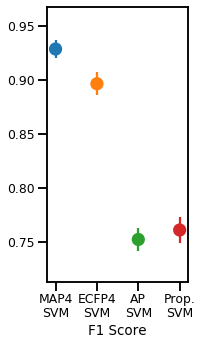

In [300]:
fig, ax = plt.subplots(figsize=(3,5))
sns.pointplot(ax =ax, x="fingerprint", y="mean", data=df_plot.query("metric=='f1'"), dodge=True, join=False, palette=sns.color_palette())
ax.set(xlabel='F1 Score', ylabel='')
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        print(x,y)
        x_coords.append(x)
        y_coords.append(y)
lb = df_plot.query("metric=='f1'")["int"].to_list()
ax.errorbar(x_coords, y_coords, yerr=[lb, lb], fmt="none", capsize=0, color = sns.color_palette())
plt.tight_layout()
plt.savefig("plots/f1.svg")

In [301]:
def ci_pointplot(input_df, x_col="metric", y_col="mean", hue_col="fingerprint", lb_col="LB", ub_col="UB"):

    palette_name = "deep"
    cv_cycles = len(input_df[x_col].unique())
    
    ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=True, join=False, palettte=palette_name)
    
    colors = sns.color_palette(palette_name, len(input_df.metric.unique())) * cv_cycles
    
    ax.axvline(0.5, ls="--", c="gray")
    
    for x in np.arange(0.5, cv_cycles, 1):
        ax.axvline(x, ls="--", c="gray")
    
    y_val = input_df[y_col]
    lb = y_val - input_df[lb_col]
    ub = input_df[ub_col] - y_val
    
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            print(x,y)
            x_coords.append(x)
            y_coords.append(y)

    for i in range(0, cv_cycles):
        _ = ax.errorbar(x_coords, y_coords, yerr=[lb, ub], fmt="none", capsize=0, color=colors)

-0.05 0.9194259704079233
0.95 0.8790331865495322
1.95 0.9286533978405871
-0.01666666666666667 0.889892247293691
0.9833333333333333 0.8265960156646223
1.9833333333333334 0.896544889880279
0.016666666666666663 0.7351336539538783
1.0166666666666666 0.5922969140488954
2.0166666666666666 0.7525883835986378
0.05 0.757714854807425
1.05 0.6129185594547569
2.05 0.7613137103093651


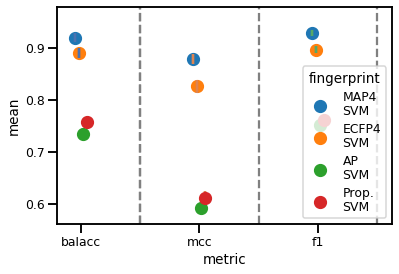

In [302]:
ci_pointplot(df_plot)

## train MAP4 SVM with all data (60k)

In [31]:
if not os.path.exists(folder + f"MAP4-SVM-coconut.all.pkl"):
    X = np.vstack(coconut.MAP4.to_numpy())
    Y = coconut.origin.to_numpy()

    classifier = svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12, C=1, kernel=map4_kernel_SVM)
      
    classifier.fit(X,Y)

    joblib.dump(classifier, folder + f"MAP4-SVM-coconut.all.pkl")
else:
    classifier = joblib.load(folder + f"MAP4-SVM-coconut.all.pkl")

In [32]:
classifier

SVC(C=1, break_ties=False, cache_size=1900, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function map4_kernel_SVM at 0x7fb21cab97b8>, max_iter=-1,
    probability=True, random_state=12, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
len(Y)

60171